# "Gaussian random walks"
> "A construction of a TensorFlow-Probability distribution implementing Gaussian random walks, with an application to stochastic volatility modeling."

- toc: false
- branch: master
- badges: true
- comments: true
- author: Yves Barmaz
- categories: [random walks, bayesian modeling, time series, tensorflow-probability]

In [1]:
#hide
import numpy as np
import pandas as pd
import pymc3 as pm

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

import matplotlib.pyplot as plt
import seaborn as sns

import arviz as az

Unlike PyMC3, TensorFlow-Probability does not provide (yet) direct implementations of random walks, but the corresponding distributions can be constructed through the application of the `tfb.Cumsum()` bijector on steps drawn from a normal distribution. In many applications, we are interested in a random walk that starts at the origin, because we measure the starting point, or model it with a specific random variable, and we want to simulate the evolution of a system subject to Brownian dynamics. This can be achieved with a zero padding at the start of the process, for instance with `tfb.Pad(paddings=((1,0),))`. The following function illustrates that construction:

In [2]:
def make_gaussian_random_walk(length, step_size=1.):
    random_walk = tfd.TransformedDistribution(
        tfd.TransformedDistribution(
            tfd.Sample(tfd.Normal(loc=0, scale=step_size), sample_shape=(length-1,)),
            tfb.Pad(paddings=((1,0),))
        ),
        tfb.Cumsum()
        )
    return random_walk

The sample method of the resulting `tfp` distribution allows us to quickly simulate realizations of a random walk.

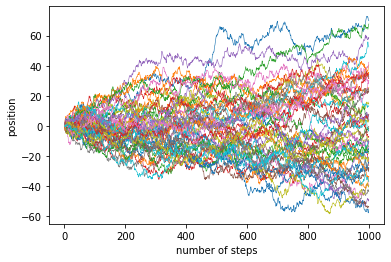

In [3]:
#hide_input
random_walk = make_gaussian_random_walk(1000)
y = random_walk.sample(50)

for i in range(y.shape[0]):
    plt.plot(y[i], linewidth=.6)
plt.xlabel('number of steps')
plt.ylabel('position')
plt.show()

To make sure that this implementation actually works, we can reproduce the analysis of the [stochastic volatility model](https://docs.pymc.io/pymc-examples/examples/case_studies/stochastic_volatility.html) treated in the PyMC3 documentation, and described as an example in the original [No-U-Turn sampler paper](https://arxiv.org/abs/1111.4246) by Hoffman and Gelman. Incidentally, it is how I found out that starting at zero was important. At first I was not doing it, and it led to an overestimation of the volatility at the onset of the time series.

The goal is to model the volatility of the S&P 500 index.

In [4]:
#hide
returns = pd.read_csv(pm.get_data("SP500.csv"), index_col="Date")
returns["change"] = np.log(returns["Close"]).diff()
returns = returns.dropna()
returns.head()

,Close,change
Date,,
2008-05-05,1407.489990,-0.004544
2008-05-06,1418.260010,0.007623
2008-05-07,1392.569946,-0.018280
2008-05-08,1397.680054,0.003663
2008-05-09,1388.280029,-0.006748


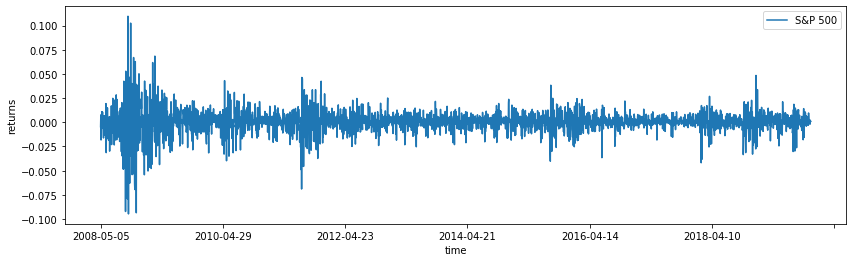

In [5]:
#hide_input
fig, ax = plt.subplots(figsize=(14, 4))
returns.plot(y="change", label="S&P 500", ax=ax, alpha=1)
ax.set(xlabel="time", ylabel="returns")
ax.legend();

The model is described in the PyMC3 example and the NUTS paper, so we just provide the TensorFlow-Probability version:

In [6]:
#hide
observed_returns = tf.constant(returns.change, dtype=tf.float32)

In [7]:
stoch_vol_mdl = tfd.JointDistributionSequential([
    #step_size
    tfd.Exponential(10, name='step_size'),
    #volatility
    lambda step_size: make_gaussian_random_walk(observed_returns.shape[0], step_size),
    #nu (degrees of freedom)
    tfd.Exponential(0.1, name='nu'),
    #returns
    lambda nu, volatility, step_size: tfd.Independent(
        tfd.StudentT(df=nu[...,tf.newaxis],
                     loc=0,
                     scale=tf.math.exp(volatility),
                     name='returns'),
        reinterpreted_batch_ndims=1
    )
])

To infer the posterior distributions, we also use the No-U-Turn sampler, and we can compare the marginal posteriors of the `nu` and `step_size` parameters as well as the estimated volatility over time with the results of the PyMC3 case study to gain confidence in the validity of the method.

In [8]:
#collapse-hide
# Specify the MCMC algorithm.
dtype = tf.dtypes.float32
nchain = 5
ssize0, vol0, nu0, _ = stoch_vol_mdl.sample(nchain)
init_state = [ssize0, vol0, nu0]
step_size = [tf.cast(i, dtype=dtype) for i in [.1, .1, .1]]
target_log_prob_fn = lambda *init_state: stoch_vol_mdl.log_prob(
    list(init_state) + [observed_returns])

# bijector to map contrained parameters to real
unconstraining_bijectors = [
    tfb.Exp(),
    tfb.Identity(),
    tfb.Exp()
]

@tf.function(autograph=False, experimental_compile=True)
def run_chain(init_state, step_size, target_log_prob_fn, unconstraining_bijectors,
              num_steps=1000, burnin=1000):

    def trace_fn(_, pkr):
        return (
            pkr.inner_results.inner_results.target_log_prob,
            pkr.inner_results.inner_results.leapfrogs_taken,
            pkr.inner_results.inner_results.has_divergence,
            pkr.inner_results.inner_results.energy,
            pkr.inner_results.inner_results.log_accept_ratio,
            pkr.inner_results.inner_results.is_accepted
               )
  
    kernel = tfp.mcmc.TransformedTransitionKernel(
      inner_kernel=tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn,
        step_size=step_size),
      bijector=unconstraining_bijectors)

    hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(
      inner_kernel=kernel,
      num_adaptation_steps=burnin,
      step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(
          inner_results=pkr.inner_results._replace(step_size=new_step_size)),
      step_size_getter_fn=lambda pkr: pkr.inner_results.step_size,
      log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio
    )

    chain_state, sampler_stat = tfp.mcmc.sample_chain(
        num_results=num_steps,
        num_burnin_steps=burnin,
        current_state=init_state,
        kernel=hmc,
        trace_fn=trace_fn)
    return chain_state, sampler_stat

# Run the chain
samples, sampler_stat = run_chain(
    init_state, step_size, target_log_prob_fn, unconstraining_bijectors)

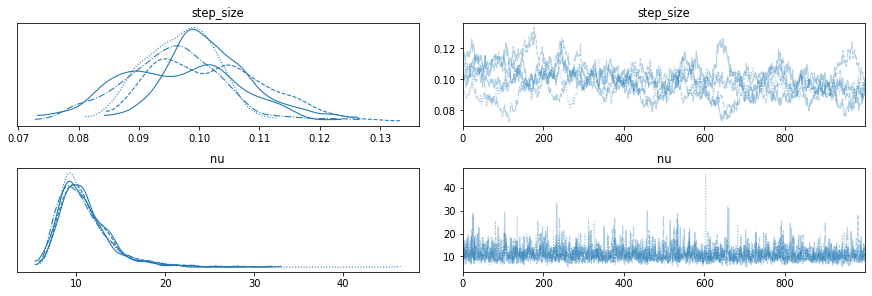

In [9]:
#hide_input
# using the pymc3 naming convention
sample_stats_name = ['lp', 'tree_size', 'diverging', 'energy', 'mean_tree_accept']
sample_stats = {k:v.numpy().T for k, v in zip(sample_stats_name, sampler_stat)}
sample_stats['tree_size'] = np.diff(sample_stats['tree_size'], axis=1)

var_name = ['step_size', 'nu']
posterior = {k:np.swapaxes(v.numpy(), 1, 0) 
             for k, v in zip(var_name, [samples[0], samples[2]])}

az_trace = az.from_dict(posterior=posterior, sample_stats=sample_stats)

az.plot_trace(az_trace)
plt.show()

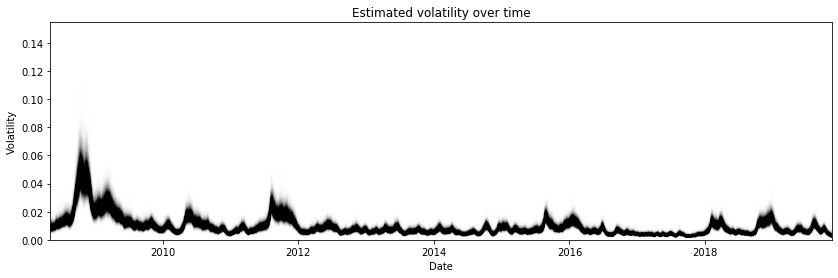

In [10]:
#hide_input
fig, ax = plt.subplots(figsize=(14, 4))

y_vals = tf.reshape(tf.math.exp(samples[1]), ((samples[1].shape[0]*samples[1].shape[1], samples[1].shape[2]))).numpy()[::5].T
x_vals = np.vstack([returns.index for _ in y_vals.T]).T.astype(np.datetime64)

plt.plot(x_vals, y_vals, "k", alpha=0.002)
ax.set_xlim(x_vals.min(), x_vals.max())
ax.set_ylim(bottom=0)
ax.set(title="Estimated volatility over time", xlabel="Date", ylabel="Volatility");